In [1]:
! pip install -r requirements.txt

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached astral-3.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached scikit_learn-1.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached auto_mix_prep-0.2.0-py3-none-any.whl
  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using 

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import os
import glob
import datetime
import pytz
import seaborn as sns
from src.apis import zeroshot_api
import pprint

warnings.filterwarnings('ignore')

In [6]:
path =  "./data"

###choose GTT model variant
modelchoice = 'small'
modelpath = f'./GTT/checkpoints/GTT-{modelchoice}'

###whether do 1st-order differencing before prediction, sometimes set autodiff=True will improve prediction accuracy
autodiff = True

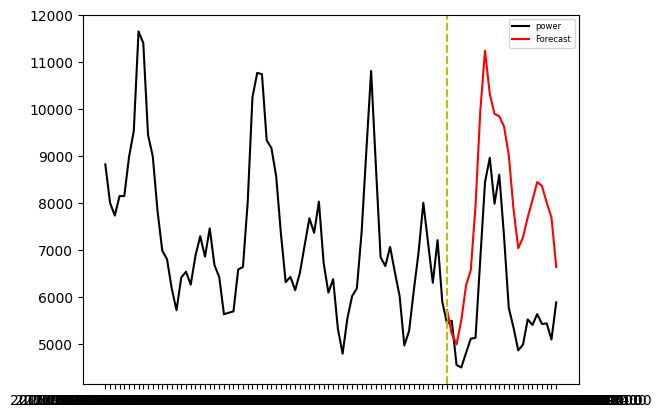

Results with prediction length 24 and context length 72
MAE: 1967.0230898962684
RMSE: 2166.8742148713413
MAPE: 34.00562192093994


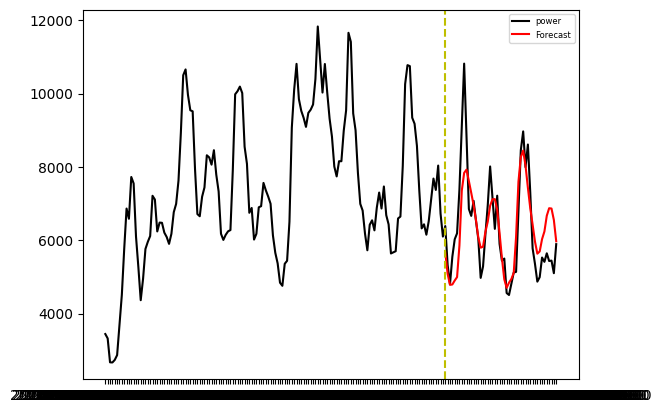

Results with prediction length 48 and context length 144
MAE: 668.1367733087528
RMSE: 879.3153164795634
MAPE: 10.420156639698853


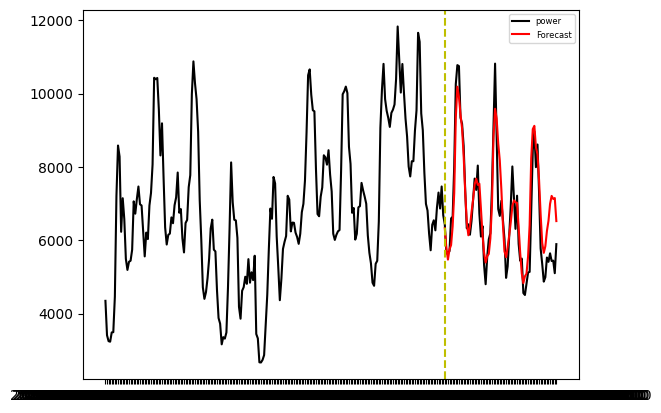

Results with prediction length 72 and context length 216
MAE: 556.1026877612845
RMSE: 728.6530975224787
MAPE: 8.862427320003292


In [7]:
dfCompl = pd.read_csv(f"{path}/train.csv", parse_dates=["date"], index_col=None)
for i in range(1, 4):
    ###define prediction length, i.e., number of forecast steps
    ###define prediction start step, it's N to last step in your data
    pred_len = pred_start =  24 * i
    data_len = 4 * pred_len
    #if i >= 2:
    #    data_len = 3 * pred_len

    
    df = dfCompl.iloc[range(len(dfCompl)-(data_len),len(dfCompl))]
    df = df.reset_index(drop=True)
    
    timefeat = df.columns[0]
    targets = [df.columns[1]]
    covariates = df.columns[range(2,len(df.columns))].array

    res = zeroshot_api.forecast(df, targets, covariates, timefeat, pred_len, pred_start, modelpath, autodiff=autodiff)
    if res['ret'] == 'success':
        zeroshot_api.plot_res(res)
    else:
        print(res)

    trueData = np.array(res["targets"][0]["values"][(data_len-pred_len):])
    preds = np.array(res["targets"][0]["preds"])

    MAE = np.mean(np.abs(trueData - preds))
    RMSE = np.sqrt(np.mean((trueData - preds)**2))
    MAPE = np.mean(np.abs((trueData - preds) / trueData)) * 100

    print(f"Results with prediction length {pred_len} and context length {data_len - pred_len}")
    print(f"MAE: {MAE}")
    print(f"RMSE: {RMSE}")
    print(f"MAPE: {MAPE}")